In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS8_DeepLearning/LDS8_DinhVietHa_thi/'

/content/gdrive/My Drive/LDS8_DeepLearning/LDS8_DinhVietHa_thi


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, TimeDistributed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Open, High, Low, Close, Adj Close, Volume to  Open

In [ ]:
dataset = pd.read_csv("./AAPL_Nov14.csv", index_col=0)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1+ KB


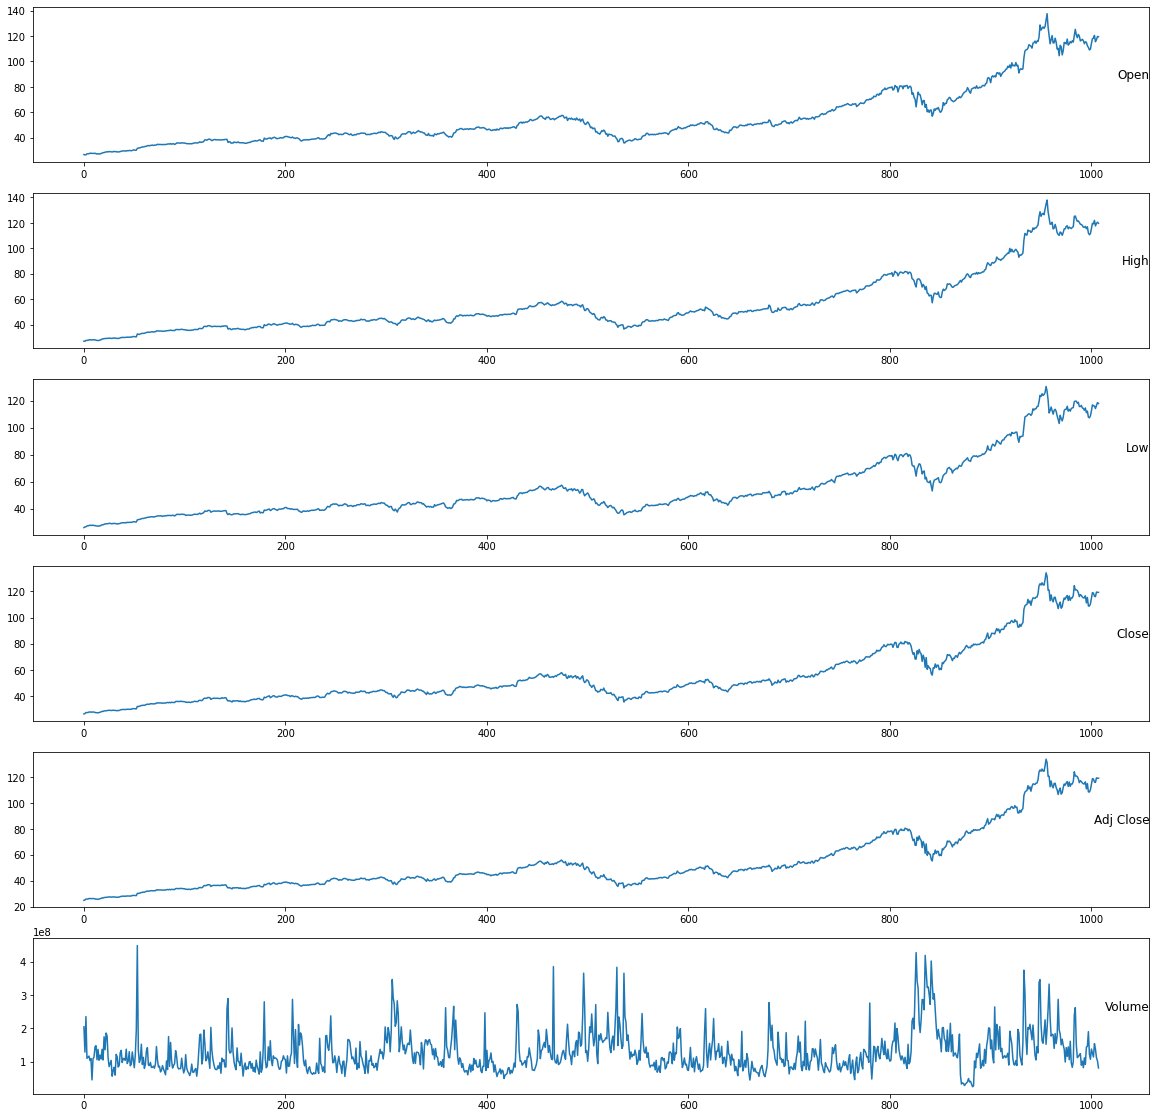

In [ ]:
values = dataset.values
groups = [0,1,2,3,4,5]
i=1
plt.figure(figsize=(20,20))
for group in groups:
  plt.subplot(len(groups), 1,i)
  plt.plot(values[:, group])
  plt.title(dataset.columns[group], y=0.5, loc='right')
  i += 1

plt.show()

Features Open, High, Low, Close and Adj Close have the same pattern of trend. Volumn feature shows little to no seasonal characteristics. When stock price is real high, the volumn decreases. When stock price was decreasing and had tentation to increase later, the volumn reached the highest. 

In [ ]:
# convert series to supervised learning

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))        
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
	return agg

In [ ]:
#load dataset
values = dataset.values

#integer encode direction 
#encoder = LabelEncoder()
#encoder.fit(values[:,4])
#values[:,4] = encoder.tranform(values[:,4])

#ensure all data is float
values = values.astype('float32')

#normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(values)
scaled = scaler.transform(values)
print("Frame as Series:")
print(scaled[:5])

#frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print("Frame as supervised learning:")
print(reframed.head())

Frame as Series:
[[2.5687814e-03 2.9262900e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.2429912e-01]
 [0.0000000e+00 0.0000000e+00 4.9756020e-03 3.2481849e-03 3.0130148e-03
  2.4526328e-01]
 [2.9292703e-04 5.7401359e-03 6.0281307e-03 9.9301785e-03 9.2111528e-03
  4.9686587e-01]
 [7.3007494e-03 6.0102493e-03 1.1362538e-02 9.8373443e-03 9.1250390e-03
  2.0140609e-01]
 [7.0979595e-03 6.4379573e-03 1.3347998e-02 1.0092571e-02 9.3617886e-03
  2.0895055e-01]]
Frame as supervised learning:
   var1(t-1)  var2(t-1)  var3(t-1)  ...   var4(t)   var5(t)   var6(t)
1   0.002569   0.000293   0.000000  ...  0.003248  0.003013  0.245263
2   0.000000   0.000000   0.004976  ...  0.009930  0.009211  0.496866
3   0.000293   0.005740   0.006028  ...  0.009837  0.009125  0.201406
4   0.007301   0.006010   0.011363  ...  0.010093  0.009362  0.208951
5   0.007098   0.006438   0.013348  ...  0.013967  0.012956  0.216862

[5 rows x 12 columns]


In [ ]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [ ]:
#drop columns we don't want to predict, only predict var1(t), drop from var2(t)
reframed.drop(reframed.columns[[6,7,8,9,10,11]], axis=1, inplace=True)
print("Frame will be used: ")
print(reframed.head())

Frame will be used: 
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)
1   0.002569   0.000293   0.000000   0.000000   0.000000   0.424299
2   0.000000   0.000000   0.004976   0.003248   0.003013   0.245263
3   0.000293   0.005740   0.006028   0.009930   0.009211   0.496866
4   0.007301   0.006010   0.011363   0.009837   0.009125   0.201406
5   0.007098   0.006438   0.013348   0.010093   0.009362   0.208951


In [ ]:
#split into train and split dataset

values = reframed.values
n_train_days = int(1008*0.8) # pick first 3 years for training
train = values[:(n_train_days+1), :]
#test
test = values[n_train_days:, :]

In [ ]:
#split into inputs and outputs
train_X, train_y = train[:, :], train[:, 0]
test_X, test_y = test[:, :], test[:, 0]
print("Before reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("After reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Before reshape:
(807, 6) (807,) (201, 6) (201,)
After reshape:
(807, 1, 6) (807,) (201, 1, 6) (201,)


In [ ]:
early = EarlyStopping(monitor='val_loss',patience=10)

checkpoint = ModelCheckpoint('Q5_AAPL_checkpoint_many.h5', save_best_only=True)

In [ ]:
#design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#fit network
history = model.fit(train_X, train_y,
                    epochs=50,
                    batch_size=72,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    callbacks = [early,checkpoint])

Epoch 1/50
12/12 - 1s - loss: 0.0214 - val_loss: 0.1803
Epoch 2/50
12/12 - 0s - loss: 0.0084 - val_loss: 0.0939
Epoch 3/50
12/12 - 0s - loss: 0.0034 - val_loss: 0.0454
Epoch 4/50
12/12 - 0s - loss: 0.0025 - val_loss: 0.0296
Epoch 5/50
12/12 - 0s - loss: 0.0022 - val_loss: 0.0274
Epoch 6/50
12/12 - 0s - loss: 0.0018 - val_loss: 0.0248
Epoch 7/50
12/12 - 0s - loss: 0.0014 - val_loss: 0.0192
Epoch 8/50
12/12 - 0s - loss: 0.0011 - val_loss: 0.0121
Epoch 9/50
12/12 - 0s - loss: 8.7722e-04 - val_loss: 0.0074
Epoch 10/50
12/12 - 0s - loss: 6.6407e-04 - val_loss: 0.0046
Epoch 11/50
12/12 - 0s - loss: 4.8649e-04 - val_loss: 0.0023
Epoch 12/50
12/12 - 0s - loss: 3.5271e-04 - val_loss: 9.4423e-04
Epoch 13/50
12/12 - 0s - loss: 2.5168e-04 - val_loss: 3.8828e-04
Epoch 14/50
12/12 - 0s - loss: 1.7789e-04 - val_loss: 2.5900e-04
Epoch 15/50
12/12 - 0s - loss: 1.2540e-04 - val_loss: 5.1355e-04
Epoch 16/50
12/12 - 0s - loss: 9.0472e-05 - val_loss: 8.7843e-04
Epoch 17/50
12/12 - 0s - loss: 6.8633e-05 - v

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


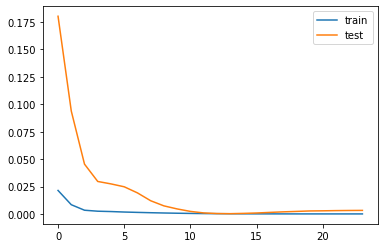

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

The graph above shows that loss of test is higher than loss of train.

In [ ]:
test_X.shape

(201, 1, 6)

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(807, 1, 6) (807,) (201, 1, 6) (201,)


In [ ]:
# make a prediction
yhat = model.predict(test_X)
print("Test_x_shape: ", test_X.shape)
test_X_now = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print("Test_x_now_shape:", test_X_now.shape)
#invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_now[:,1:]), axis=1)
print("inv_y_hat_shape:", inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
print("inv_yhat:", inv_yhat.shape)

#reshape to original
inv_yhat = inv_yhat[:,0]

#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_now[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Test_x_shape:  (201, 1, 6)
Test_x_now_shape: (201, 6)
inv_y_hat_shape: (201, 6)
inv_yhat: (201, 6)


In [ ]:
#calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("Test RMSE: %.3f" %rmse)

Test RMSE: 6.319


In [ ]:
#make a prediction of y
y_train_hat = model.predict(train_X)
train_X_now = train_X.reshape((train_X.shape[0], train_X.shape[2]))
#invert scaling for forecast
inv_y_train_hat = np.concatenate((y_train_hat, train_X_now[:,1:]), axis=1)
inv_y_train_hat = scaler.inverse_transform(inv_y_train_hat)
inv_y_train_hat = inv_y_train_hat[:,0]

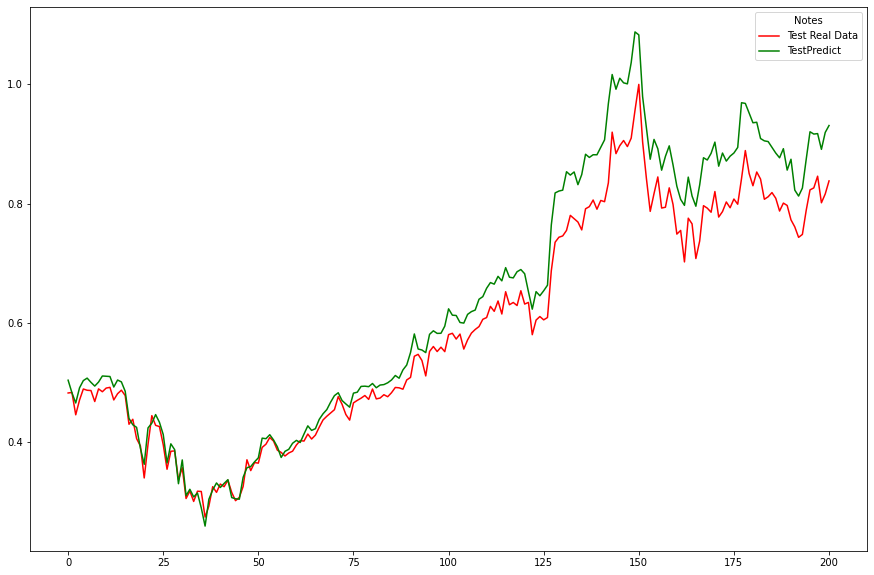

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(test_y, label="Test Real Data", color='red')
plt.plot(yhat, label='TestPredict', color='green')

plt.legend(title="Notes")
plt.show()

The graph above shows that the model predicts well, as the real and predict data share a similar trend. The beginning seems to fit in completely, while the end shows a small deviation, with predict is clearly higher than real.

In [ ]:
print('Val_loss train')
model.evaluate(train_X, train_y)

Val_loss train
26/26 [==============================] - 0s 1ms/step - loss: 3.6586e-05


3.658552304841578e-05

In [ ]:
print("Val_loss test")
model.evaluate(test_X, test_y)

Val_loss test
7/7 [==============================] - 0s 2ms/step - loss: 0.0032


0.0032441983930766582